In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import string

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Loading data from CSV file
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_Lang Translation/new_data.csv')

In [8]:
# Replacing Column names to English and Hindi
english_sentences = df['English'].tolist()
hindi_sentences = df['Hindi'].tolist()

In [9]:
# Remove punctuations from English sentences
english_sentences = [''.join(char for char in sentence if char not in string.punctuation) for sentence in english_sentences]
# Remove punctuations from Hindi sentences
hindi_sentences = [''.join(char for char in sentence if char not in string.punctuation) for sentence in hindi_sentences]


In [10]:
# Tokenizing English and Hindi sentences
tokenizer_en = Tokenizer(oov_token="<OOV>")
tokenizer_en.fit_on_texts(english_sentences)
vocab_size_en = len(tokenizer_en.word_index) + 1
english_sequences = tokenizer_en.texts_to_sequences(english_sentences)

tokenizer_hi = Tokenizer(oov_token="<OOV>")
tokenizer_hi.fit_on_texts(hindi_sentences)
vocab_size_hi = len(tokenizer_hi.word_index) + 1
hindi_sequences = tokenizer_hi.texts_to_sequences(hindi_sentences)

In [11]:
# Padding sequences to have the same length
max_len = max(len(english_sequence) for english_sequence in english_sequences)
english_sequences = pad_sequences(english_sequences, maxlen=max_len, padding='post')
hindi_sequences = pad_sequences(hindi_sequences, maxlen=max_len, padding='post')

In [12]:
# Verify the shapes of sequences
print("Shape of English sequences:", english_sequences.shape)
print("Shape of Hindi sequences:", hindi_sequences.shape)

Shape of English sequences: (2979, 22)
Shape of Hindi sequences: (2979, 22)


In [13]:
# One-hot encode the Hindi sequences
hindi_sequences_encoded = to_categorical(hindi_sequences, num_classes=vocab_size_hi)

In [14]:
# Split the data into training and testing sets
english_train, english_test, hindi_train, hindi_test = train_test_split(english_sequences, hindi_sequences_encoded, test_size=0.2, random_state=42)

In [15]:
# Create the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size_en, output_dim=512, input_length=max_len))
model.add(LSTM(512, return_sequences=True))  # Return sequences for each time step
model.add(Dense(vocab_size_hi, activation='softmax'))

In [16]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
# Train the model
history =model.fit(english_sequences, hindi_sequences_encoded, epochs=50, batch_size=1, validation_data=(english_test, hindi_test))

Epoch 1/50
2979/2979 [==============================] - 29s 9ms/step - loss: 2.1779 - accuracy: 0.6991 - val_loss: 1.8420 - val_accuracy: 0.7159
Epoch 2/50
2979/2979 [==============================] - 21s 7ms/step - loss: 1.8293 - accuracy: 0.7145 - val_loss: 1.5436 - val_accuracy: 0.7294
Epoch 3/50
2979/2979 [==============================] - 22s 7ms/step - loss: 1.5557 - accuracy: 0.7282 - val_loss: 1.2022 - val_accuracy: 0.7601
Epoch 4/50
2979/2979 [==============================] - 21s 7ms/step - loss: 1.2222 - accuracy: 0.7531 - val_loss: 0.8053 - val_accuracy: 0.8231
Epoch 5/50
2979/2979 [==============================] - 22s 7ms/step - loss: 0.8840 - accuracy: 0.7984 - val_loss: 0.5373 - val_accuracy: 0.8745
Epoch 6/50
2979/2979 [==============================] - 21s 7ms/step - loss: 0.6266 - accuracy: 0.8506 - val_loss: 0.3916 - val_accuracy: 0.9073
Epoch 7/50
2979/2979 [==============================] - 22s 7ms/step - loss: 0.4814 - accuracy: 0.8838 - val_loss: 0.3252 - val_ac

In [18]:
# Print accuracy and loss values
print("Training Accuracy:", history.history['accuracy'][-1])
print("Training Loss:", history.history['loss'][-1])

Training Accuracy: 0.9285452961921692
Training Loss: 0.21923789381980896


In [19]:
# Make predictions
def translate_sentence(input_sentence):
    input_seq = tokenizer_en.texts_to_sequences([input_sentence])
    input_seq = pad_sequences(input_seq, maxlen=max_len, padding='post')
    predicted_seq = model.predict(input_seq)
    predicted_seq = np.argmax(predicted_seq, axis=-1)
    predicted_sentence = []
    for token in predicted_seq[0]:
        if token != 0:
            predicted_sentence.append(list(tokenizer_hi.word_index.keys())[list(tokenizer_hi.word_index.values()).index(token)])
    return ' '.join(predicted_sentence)

In [24]:
# Test the model
input_sentence = "Hello!"
translated_sentence = translate_sentence(input_sentence)
print(f'Input: {input_sentence}')
print(f'Translation: {translated_sentence}')

1/1 [==============================] - 0s 18ms/step
Input: Hello!
Translation: नमस्ते।


In [25]:
# Test the model
input_sentence = "How are you?"
translated_sentence = translate_sentence(input_sentence)
print(f'Input: {input_sentence}')
print(f'Translation: {translated_sentence}')

1/1 [==============================] - 0s 19ms/step
Input: How are you?
Translation: तुम कैसे हो


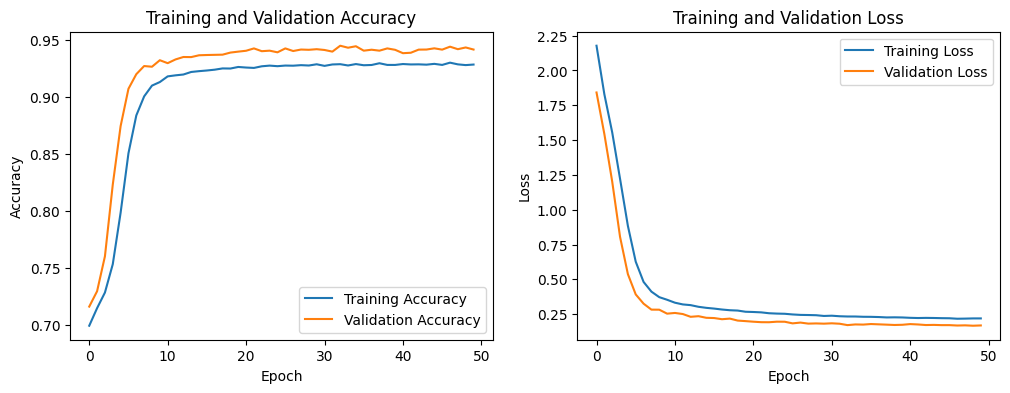

In [22]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

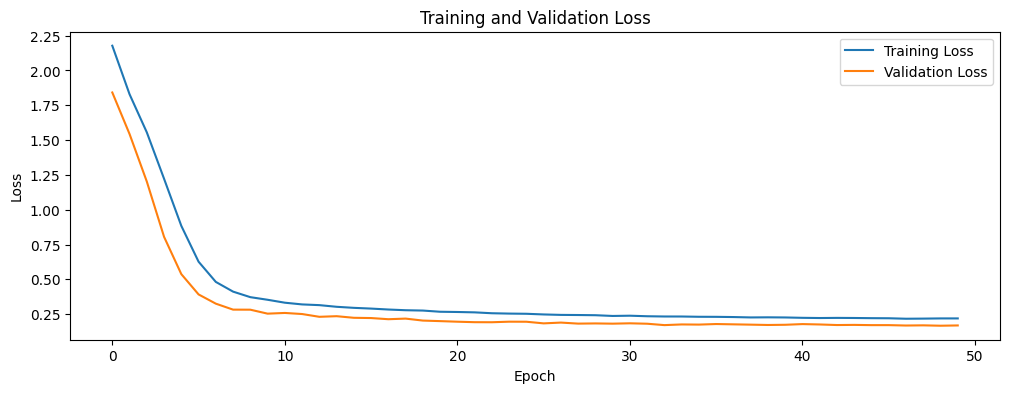

In [23]:
# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()